#Downloading the dataset

In [ ]:
!nvidia-smi

Thu Mar 10 17:07:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(train_data, test_data), ds_info = tfds.load("food101",
                                             split=["train", "validation"],
                                             as_supervised=True,
                                             with_info=True,
                                             shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteBQ33X8/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteBQ33X8/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


#Features of the Dataset

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

#Getting Helper Functions ready

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
def plot_curves(history):
  loss = history.history["loss"]
  accuracy = history.history["accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, accuracy, label="accuracy")

  plt.legend()

  plt.figure()

  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]

  plt.plot(epochs, val_loss, label="val_loss")
  plt.plot(epochs, val_accuracy, label="val_Accuracy")

  plt.legend()

In [ ]:
def model_checkpoint(filename):
  callback = tf.keras.callbacks.ModelCheckpoint(filename,
                                                monitor="val_accuracy",
                                                save_weights_only=True,
                                                save_best_only=True,
                                                save_freq='epoch')
  return callback

In [ ]:
import datetime

def create_tensorboard_callback(file_name, exp_name):
  log_dir = file_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%D-%H%M%S")
  callback = tf.keras.callbacks.TensorBoard(log_dir)
  return callback

In [ ]:
def preprocessing_image(image, label, img_size=224):
  img = tf.image.resize(image, [img_size, img_size])
  return tf.cast(img, tf.float32), label

#Exploring the Dataset

In [ ]:
train_one_sample = train_data.take(1)

for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape},
  Image dtype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3),
  Image dtype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 38
  Class name (str form): fish_and_chips
  


In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

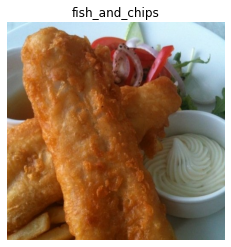

In [ ]:
plt.title(class_names[label.numpy()])
plt.imshow(image)
plt.axis(False)

#Checking GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e5d68366-0109-28d0-cab9-dfe0d9fa2eb0)


#Batching & Preparing Datasets

In [ ]:
train_data = train_data.map(map_func=preprocessing_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocessing_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#Setup Mixed Precision Training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

#Building a feature Extraction layer

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Data Augmentation

In [ ]:
Data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2)
],  name="Data_Augmentation_Layer")

#Training a Feature Extraction Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

inputs = layers.Input((224, 224, 3), dtype=tf.float16, name="input_layer")
#x = Data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="Average_Pooling_layer") (x)
x = layers.Dense(len(class_names)) (x)
outputs = layers.Activation("sigmoid", dtype=tf.float32, name="sigmoid32") (x)

model_0 = keras.Model(inputs, outputs)

In [ ]:
model_0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback("training_logs", 
                                                               "efficientnetb0_101_classes_all_data_feature_extract"),
                                   model_checkpoint("model_0_checkpoints/model_0_checkpoints.ckpt")]
                        )

Epoch 1/5
2368/2368 [==============================] - 182s 69ms/step - loss: 1.8236 - accuracy: 0.5560 - val_loss: 1.2498 - val_accuracy: 0.6698
Epoch 2/5
2368/2368 [==============================] - 163s 68ms/step - loss: 1.2948 - accuracy: 0.6659 - val_loss: 1.1381 - val_accuracy: 0.6896
Epoch 3/5
2368/2368 [==============================] - 159s 66ms/step - loss: 1.1442 - accuracy: 0.7038 - val_loss: 1.0913 - val_accuracy: 0.7082
Epoch 4/5
2368/2368 [==============================] - 160s 67ms/step - loss: 1.0466 - accuracy: 0.7261 - val_loss: 1.0608 - val_accuracy: 0.7166
Epoch 5/5
2368/2368 [==============================] - 160s 67ms/step - loss: 0.9717 - accuracy: 0.7446 - val_loss: 1.0664 - val_accuracy: 0.7172


In [ ]:
model_0.evaluate(test_data)

790/790 [==============================] - 54s 66ms/step - loss: 1.0565 - accuracy: 0.7149


[1.0564796924591064, 0.7149307131767273]

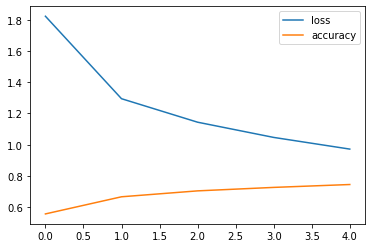

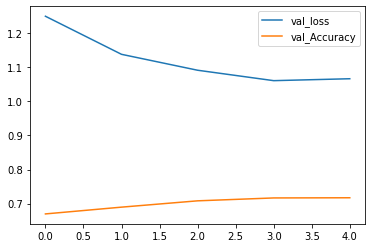

In [ ]:
plot_curves(history_0)

#Loading Weights and Fine tuning the model

In [ ]:
model_0.load_weights("model_0_checkpoints/model_0_checkpoints.ckpt")

#Setting up New Callbacks

In [ ]:
import tensorflow as tf

In [ ]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=3
                                                 )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, 
                                                 patience=2, 
                                                 verbose=1,
                                                 min_lr=1e-7)

#Fine Tuning the Best model

In [ ]:
base_model.trainable = True

In [ ]:
model_0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

history_2 = model_0.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback("training_logs", 
                                                               "efficientnetb0_101_classes_all_data_best_model"),
                                   model_checkpoint("model_2_checkpoints/model_2_checkpoints.ckpt"),
                                   earlyStopping,
                                   reduce_lr]
                        )

Epoch 1/100
2368/2368 [==============================] - 344s 139ms/step - loss: 0.8351 - accuracy: 0.7716 - val_loss: 0.8407 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 329s 138ms/step - loss: 0.5110 - accuracy: 0.8570 - val_loss: 0.8527 - val_accuracy: 0.7770 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.9172
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 326s 137ms/step - loss: 0.2876 - accuracy: 0.9172 - val_loss: 0.9265 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 327s 137ms/step - loss: 0.0697 - accuracy: 0.9832 - val_loss: 0.9986 - val_accuracy: 0.7881 - lr: 2.0000e-05


In [ ]:
model_0.evaluate(test_data)

790/790 [==============================] - 52s 63ms/step - loss: 0.9865 - accuracy: 0.7894


[0.9864969849586487, 0.7894257307052612]

In [ ]:
model_0.load_weights("model_2_checkpoints/model_2_checkpoints.ckpt")

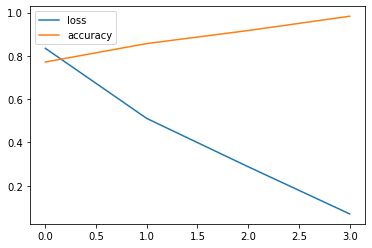

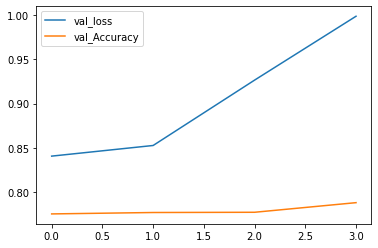

In [ ]:
plot_curves(history_2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = "/content/drive/MyDrive/Model_0"

In [ ]:
model_0.save(directory)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Model_0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Model_0/assets
